In [15]:
import os
import json
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, matthews_corrcoef
import h5py
import torch
import torch.nn as nn

In [ ]:
# Folder paths
results_folder = '/Users/elcachorrohumano/workspace/MusicNN/ml/specs/fine_tuning/results'
models_folder = '/Users/elcachorrohumano/workspace/MusicNN/ml/specs/fine_tuning/models'

def load_results(folder):
    """Load all results JSON files from the folder."""
    results = []
    for file_name in sorted(os.listdir(folder)):
        if file_name.endswith('.json'):
            with open(os.path.join(folder, file_name), 'r') as f:
                results.extend(json.load(f))
    return results

def find_best_model(results):
    """Find the model with the best validation accuracy."""
    best_model = max(results, key=lambda x: x['best_val_acc'])
    return best_model

def plot_losses(metrics):
    """Plot training and validation losses through epochs."""
    plt.figure(figsize=(10, 6))
    plt.plot(metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid()
    plt.show()

def calculate_metrics(y_true, y_pred, y_proba):
    """Calculate and display metrics for evaluation."""
    auc_roc = roc_auc_score(y_true, y_proba)
    report = classification_report(y_true, y_pred, output_dict=True)
    mcc = matthews_corrcoef(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print("Confusion Matrix:")
    print(cm)

    print("\nClassification Report:")
    for key, value in report.items():
        print(f"{key}: {value}")

    print("\nMatthews Correlation Coefficient (MCC):", mcc)
    print("\nAUC-ROC Score:", auc_roc)

    # Plot AUC-ROC Curve
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'AUC-ROC = {auc_roc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC-ROC Curve')
    plt.legend()
    plt.grid()
    plt.show()

def evaluate_model(best_model, test_loader, device):
    """Evaluate the best model on the test set."""
    model_path = best_model['model_path']
    # Correct the model path
    model_path = os.path.join(models_folder, os.path.basename(model_path))
    print(f"Loading best model from: {model_path}")

    # Load model
    model = ImprovedCNN(height, width, num_classes,
                        conv_channels=best_model['params']['conv_channels'],
                        fc_units=best_model['params']['fc_units'],
                        dropout_rate=best_model['params']['dropout_rate']).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Evaluate
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            predictions = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()


            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predictions)
            all_probs.extend(probabilities)

    # Calculate and display metrics
    calculate_metrics(all_labels, all_preds, all_probs)


Best Model Parameters:
{'conv_channels': [32, 64, 128], 'fc_units': [1024, 512], 'dropout_rate': 0.25, 'learning_rate': 0.001, 'weight_decay': 0.001}
Best Validation Accuracy: 0.8309248554913294


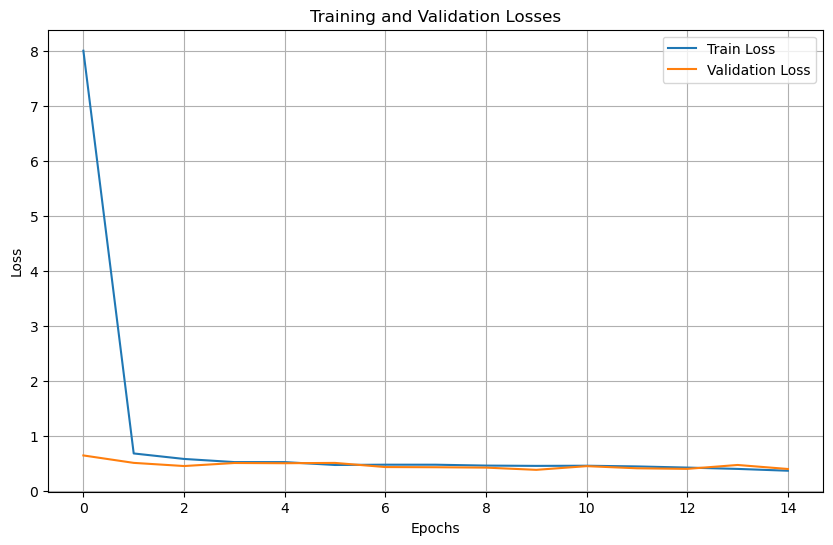

In [ ]:

# Load results
results = load_results(results_folder)

# Find the best model
best_model = find_best_model(results)
print("Best Model Parameters:")
print(best_model['params'])
print("Best Validation Accuracy:", best_model['best_val_acc'])

# Plot losses
plot_losses(best_model['metrics'])

In [8]:
def load_data(filepath):
    with h5py.File(filepath, 'r') as f:
        spectrograms = torch.tensor(f['spectrograms'][:], dtype=torch.float32).unsqueeze(1)
        labels = torch.tensor(f['labels'][:], dtype=torch.long)
    return spectrograms, labels

# Load data from mounted files
train_spectrograms, train_labels = load_data('/Users/elcachorrohumano/workspace/MusicNN/data/train/spec_train.h5')
val_spectrograms, val_labels = load_data('/Users/elcachorrohumano/workspace/MusicNN/data/validation/spec_validation.h5')
test_spectrograms, test_labels = load_data('/Users/elcachorrohumano/workspace/MusicNN/data/test/spec_test.h5')

_, channels, height, width = train_spectrograms.shape
print(f"Train specs: {train_spectrograms.shape}, labels: {train_labels.shape}")
print(f"Val specs: {val_spectrograms.shape}, labels: {val_labels.shape}")
print(f"Test specs: {test_spectrograms.shape}, labels: {test_labels.shape}")

Train specs: torch.Size([2403, 1, 128, 641]), labels: torch.Size([2403])
Val specs: torch.Size([692, 1, 128, 641]), labels: torch.Size([692])
Test specs: torch.Size([348, 1, 128, 641]), labels: torch.Size([348])


In [9]:
from torch.utils.data import DataLoader, TensorDataset

# Define batch size
batch_size = 64  # You can adjust this based on your system's memory capacity

# Create TensorDataset from test spectrograms and labels
test_dataset = TensorDataset(test_spectrograms, test_labels)

# Create DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [12]:
# Use MPS for Mac GPUs if available
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print("Using device:", device)

Using device: mps


In [16]:
class ImprovedCNN(nn.Module):
    def __init__(self, input_height, input_width, num_classes, conv_channels=[32, 64, 128], fc_units=[512, 256], dropout_rate=0.25):
        super(ImprovedCNN, self).__init__()
        self.conv_layers = nn.ModuleList()
        in_channels = 1

        for out_channels in conv_channels:
            self.conv_layers.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
                nn.Dropout2d(dropout_rate)
            ))
            in_channels = out_channels

        self.height_after_conv = input_height // (2 ** len(conv_channels))
        self.width_after_conv = input_width // (2 ** len(conv_channels))

        fc_layers = []
        in_features = conv_channels[-1] * self.height_after_conv * self.width_after_conv

        for units in fc_units:
            fc_layers.extend([
                nn.Linear(in_features, units),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
            ])
            in_features = units

        fc_layers.append(nn.Linear(in_features, num_classes))
        self.fc = nn.Sequential(*fc_layers)

    def forward(self, x):
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
        x = x.view(-1, x.size(1) * self.height_after_conv * self.width_after_conv)
        return self.fc(x)

Loading best model from: /Users/elcachorrohumano/workspace/MusicNN/ml/specs/fine_tuning/models/model_9.pth


/var/folders/c9/1rs_w22n5l76b34bm7s0_q9r0000gn/T/ipykernel_51027/1115632424.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,

Confusion Matrix:
[[127  48]
 [ 10 163]]

Classification Report:
0: {'precision': 0.927007299270073, 'recall': 0.7257142857142858, 'f1-score': 0.8141025641025641, 'support': 175.0}
1: {'precision': 0.7725118483412322, 'recall': 0.9421965317919075, 'f1-score': 0.8489583333333334, 'support': 173.0}
accuracy: 0.8333333333333334
macro avg: {'precision': 0.8497595738056526, 'recall': 0.8339554087530967, 'f1-score': 0.8315304487179487, 'support': 348.0}
weighted avg: {'precision': 0.8502035262508504, 'recall': 0.8333333333333334, 'f1-score': 0.8314302884615385, 'support': 348.0}

Matthews Correlation Coefficient (MCC): 0.683532300438174

AUC-ROC Score: 0.9027580511973575


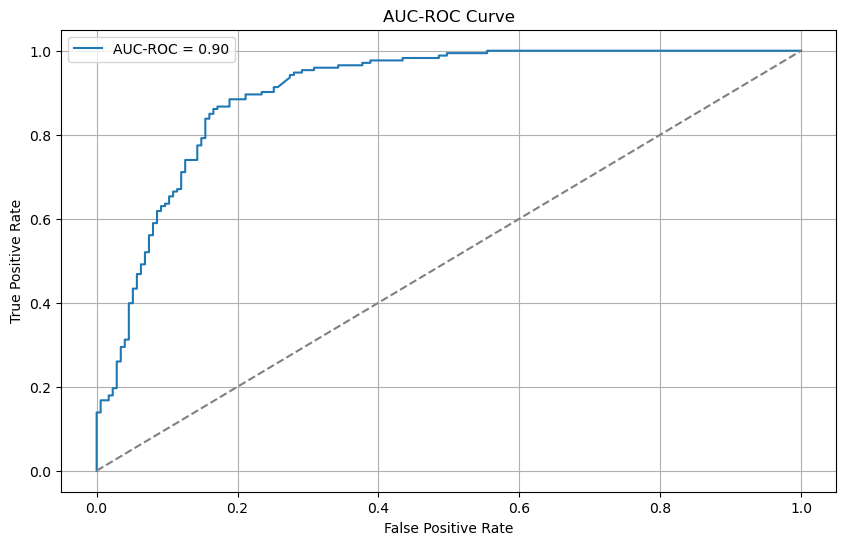

In [18]:
num_classes = len(set(train_labels.numpy()))
evaluate_model(best_model, test_loader, device)
